Pre Data Cleaning Steps:
1. Make sure you have a column 'Time' this should be calculated by multiplying: Frame# * 60 * 8 
2. Make sure you have a Microglia ID column
3. Make sure you have a Speed column, originally this is output in seconds. For our purposes multiply by 60 to calculate the speed per minute

/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_3113/1560238044.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('rainbow', len(mice))


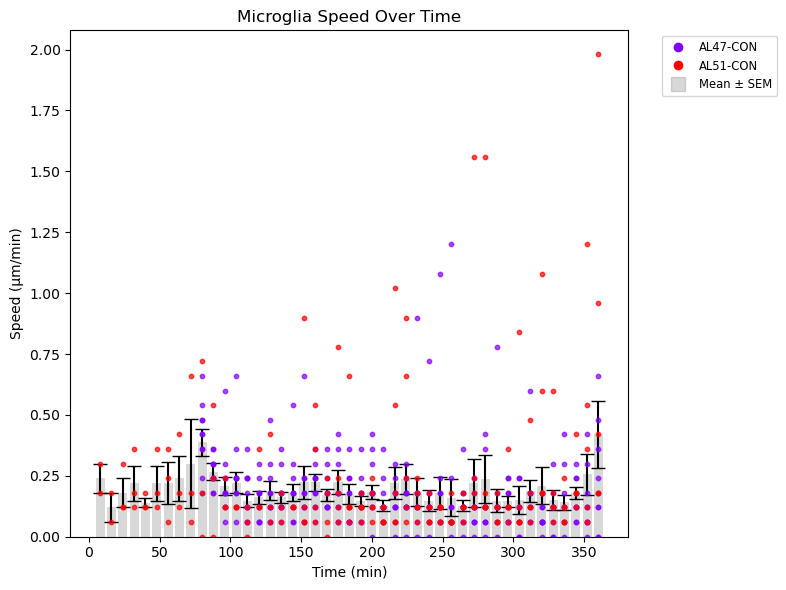

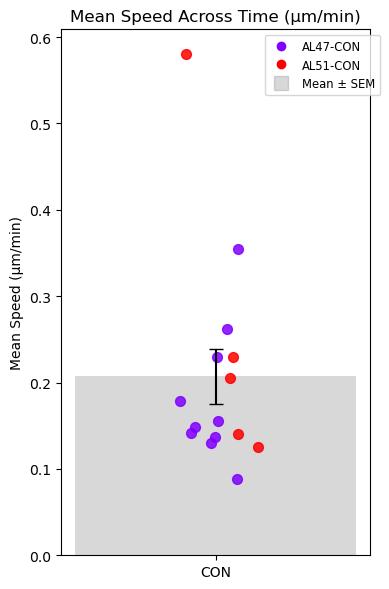

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example: load multiple CSVs (one per mouse)
mouse_files = {
    'AL47-CON': '/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/Statistics/Combined Stats/CON/Unknown/AL47/Speed.csv',
    'AL51-CON': '//Users/alexlawson/Masters-Data-Final/Live-imaging/Results/Statistics/Combined Stats/CON/Unknown/AL51/Speed.csv'
}

dfs = []
for mouse, path in mouse_files.items():
    df = pd.read_csv(path)
    df['Mouse'] = mouse
    dfs.append(df)

# Combine into one dataframe
df_all = pd.concat(dfs, ignore_index=True)

# ---------------- Common setup for both plots: colors by mouse ----------------
mice = sorted(df_all['Mouse'].unique())
cmap = plt.cm.get_cmap('rainbow', len(mice))
mouse_colors = {m: cmap(i) for i, m in enumerate(mice)}

# ---------------- Plot 1: Speed over time (ONE mean bar per timepoint) ----------------
# Overall mean ± SEM across all mice at each time
summary = df_all.groupby('Time', as_index=False)['Speed'].agg(mean='mean', sem='sem')

# Bar width = 80% of median step (fallback if only one timepoint)
time_sorted = np.sort(summary['Time'].unique())
step = np.median(np.diff(time_sorted)) if len(time_sorted) > 1 else 1.0
bar_width = 0.8 * step if np.isfinite(step) and step > 0 else 0.5

fig, ax = plt.subplots(figsize=(8, 6))

# Grey bars: overall mean ± SEM at each timepoint (not split by mouse)
ax.bar(
    summary['Time'],
    summary['mean'],
    width=bar_width,
    yerr=summary['sem'],
    capsize=5,
    alpha=0.3,
    color='grey',
    zorder=1
)

# Scatter: all microglia points, colored by mouse (no labels to avoid dup legend)
for mouse in mice:
    grp = df_all[df_all['Mouse'] == mouse]
    ax.scatter(
        grp['Time'],
        grp['Speed'],
        s=10,
        alpha=0.7,
        color=mouse_colors[mouse],
        zorder=2
    )

ax.set_xlabel('Time (min)')
ax.set_ylabel('Speed (µm/min)')
ax.set_title('Microglia Speed Over Time')

# Custom legend: mouse colors + Mean ± SEM
handles = [
    plt.Line2D([0],[0], marker='o', color=mouse_colors[m], label=m,
               markersize=6, linestyle='None')
    for m in mice
]
handles.append(
    plt.Line2D([0],[0], marker='s', color='grey', label='Mean ± SEM',
               alpha=0.3, markersize=10, linestyle='None')
)
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()
plt.show()

# ---------------- Plot 2: Overall mean ± SEM + per-mouse microglia means ----------------
per_cell = df_all.groupby(['Mouse', 'MicrogliaID'])['Speed'].mean().reset_index()
overall_mean = per_cell['Speed'].mean()
overall_sem = per_cell['Speed'].sem()

fig, ax = plt.subplots(figsize=(4, 6))

# One bar for overall mean ± SEM (across all microglia from all mice)
ax.bar(
    1,
    overall_mean,
    width=0.3,
    yerr=overall_sem,
    capsize=5,
    alpha=0.3,
    color='grey'
)

# Scatter microglia means, colored by mouse
jitter_strength = 0.02
for mouse in mice:
    mouse_cells = per_cell[per_cell['Mouse'] == mouse]
    x_jitter = np.random.normal(0, jitter_strength, size=len(mouse_cells))
    ax.scatter(
        1 + x_jitter,
        mouse_cells['Speed'],
        color=mouse_colors[mouse],
        s=50,
        alpha=0.85
    )

ax.set_xticks([1])
ax.set_xticklabels(['CON'])
ax.set_ylabel('Mean Speed (µm/min)')
ax.set_title('Mean Speed Across Time (µm/min)')

# Legend
handles = [
    plt.Line2D([0], [0], marker='o', color=mouse_colors[m], label=m,
               markersize=6, linestyle='None')
    for m in mice
]
handles.append(
    plt.Line2D([0], [0], marker='s', color='grey', label='Mean ± SEM',
               alpha=0.3, markersize=10, linestyle='None')
)
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()
plt.show()


/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_3113/2616642974.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('rainbow', len(mice))


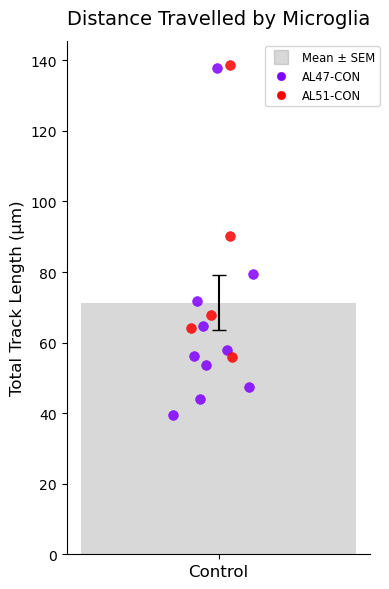

In [27]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === User-defined parameters ===
MOUSE_FILES = {
    # mouse label -> csv path
    'AL47-CON': "/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/Statistics/Combined Stats/CON/Unknown/AL47/Track_Length.csv",
    'AL51-CON': "/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/Statistics/Combined Stats/CON/Unknown/AL51/Track_Length.csv",
}

ID_COL     = "MicrogliaID"              # only used for diagnostics; plotting colors by Mouse
VALUE_COL  = "Track Length" # y-values
XTICK_LABEL = "Control"                 # x-axis label under the single bar
Y_LABEL     = "Total Track Length (µm)"
PLOT_TITLE  = "Distance Travelled by Microglia"
SAVE_PATH   = None                       # e.g., "output.png" or None to display

def plot_microglia():
    # 1) Load, tag by mouse, and clean
    dfs = []
    for mouse, path in MOUSE_FILES.items():
        df = pd.read_csv(path, encoding="latin1")   # aka Windows-1252
        df['Mouse'] = mouse
        dfs.append(df)

    df_all = pd.concat(dfs, ignore_index=True)

    # Standardize columns & coerce numeric
    df_all.columns = [c.strip() for c in df_all.columns]
    if ID_COL not in df_all.columns:
        # optional: try common variants if needed
        for cand in ['Microglia Id', 'Microglia_ID', 'CellID', 'TrackID']:
            if cand in df_all.columns:
                df_all = df_all.rename(columns={cand: ID_COL})
                break

    # keep only required columns
    needed = ['Mouse', VALUE_COL]
    if ID_COL in df_all.columns:
        needed.append(ID_COL)
    df_all = df_all[needed].copy()

    # coerce numeric and drop NAs
    df_all[VALUE_COL] = pd.to_numeric(df_all[VALUE_COL], errors='coerce')
    df_all = df_all.dropna(subset=['Mouse', VALUE_COL])

    # 2) Summary stats (overall across all mice)
    values = df_all[VALUE_COL].to_numpy()
    mean_val = float(np.mean(values))
    sem_val  = float(np.std(values, ddof=1) / np.sqrt(len(values)))

    # Colors (by mouse) — rainbow, preserving first-seen order in df_all
    mice = pd.unique(df_all['Mouse'])
    cmap = plt.cm.get_cmap('rainbow', len(mice))
    mouse_colors = {m: cmap(i) for i, m in enumerate(mice)}


    # 4) Make the figure
    fig, ax = plt.subplots(figsize=(4, 6))

    # a) One grey bar for overall mean ± SEM
    ax.bar(
        0,
        mean_val,
        yerr=sem_val,
        capsize=5,
        color='grey',
        alpha=0.3,
        width=0.4,
        label='Mean ± SEM'
    )

    # b) Scatter all individual values, colored by mouse (single call per mouse)
    jitter_strength = 0.03
    for m in mice:
        vals = df_all.loc[df_all['Mouse'] == m, VALUE_COL].to_numpy()
        if len(vals) == 0:
            continue
        x = np.zeros_like(vals, dtype=float) + np.random.normal(0, jitter_strength, size=len(vals))
        ax.scatter(
            x,
            vals,
            color=mouse_colors[m],
            s=50,
            alpha=0.85,
            linewidths=0.4,
            label=m
        )

    # 5) Styling
    ax.set_xticks([0])
    ax.set_xticklabels([XTICK_LABEL], fontsize=12)
    ax.set_ylabel(Y_LABEL, fontsize=12)
    ax.set_title(PLOT_TITLE, fontsize=14, pad=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 6) Custom legend: one entry per mouse + one for Mean±SEM (no dupes)
    handles = [
        plt.Line2D([0],[0], marker='s', color='grey',
                   label='Mean ± SEM', markersize=10,
                   linestyle='None', alpha=0.3)
    ] + [
        plt.Line2D([0],[0], marker='o', color=mouse_colors[m],
                   label=m, markersize=6, linestyle='None',
                   markeredgewidth=0.4)
        for m in mice
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05,1), fontsize='small')

    plt.tight_layout()

    # 7) Save or show
    if SAVE_PATH:
        fig.savefig(SAVE_PATH, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {SAVE_PATH}")
    else:
        plt.show()

if __name__ == "__main__":
    plot_microglia()


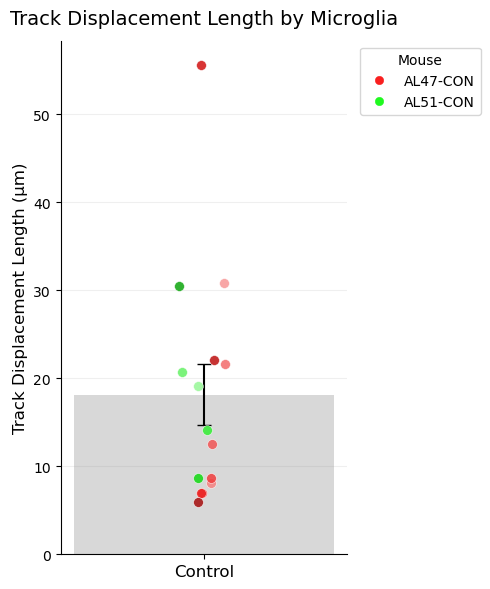

In [36]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import os

# === User-defined parameters ===
MOUSE_FILES = {
    # mouse label -> csv path
    'AL47-CON': "/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/Statistics/Combined Stats/CON/Unknown/AL47/Track_Displacement_Length.csv",
    'AL51-CON': "/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/Statistics/Combined Stats/CON/Unknown/AL51/Track_Displacement_Length.csv",
}

ID_COL      = "MicrogliaID"           # only used to assign shades per cell (if present)
VALUE_COL   = "Track Displacement Length"          # y-values
XTICK_LABEL = "Control"               # x-axis label under the single bar
Y_LABEL     = "Track Displacement Length (µm)"
PLOT_TITLE  = "Track Displacement Length by Microglia"
SAVE_PATH   = None                    # e.g., "output.png" or None to display

np.random.seed(42)  # reproducible jitter

# -------------------- Color helpers (same behavior as earlier code) --------------------
def _very_distinct_mouse_colors(mice, light=0.55, sat=0.95):
    """
    Assign very distinct base hues in a fixed, human-friendly order:
    1: red, 2: green, 3: blue, 4: magenta, 5: yellow/orange, 6: cyan, 7: purple,
    8: orange, 9: teal, 10: pink... then evenly spaced hues if >10 mice.
    Returns dict: mouse -> RGBA tuple.
    """
    H_BASE = [
        0.00,        # red
        1/3,         # green
        2/3,         # blue
        5/6,         # magenta
        1/6,         # yellow/orange
        0.50,        # cyan
        0.75,        # purple/violet
        1/12,        # orange
        7/12,        # teal
        11/12,       # pink/crimson
    ]
    if len(mice) <= len(H_BASE):
        hues = H_BASE[:len(mice)]
    else:
        extra = len(mice) - len(H_BASE)
        hues = H_BASE + list(np.linspace(0, 1, extra, endpoint=False))

    mouse_colors = {}
    for m, h in zip(mice, hues):
        r, g, b = colorsys.hls_to_rgb(h, light, sat)  # colorsys uses HLS
        mouse_colors[m] = (r, g, b, 1.0)
    return mouse_colors

def _rgb_to_hls(rgb):
    r, g, b = rgb[:3]
    return colorsys.rgb_to_hls(r, g, b)

def _hls_to_rgb(h, l, s):
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b, 1.0)

def _microglia_shades_by_mouse(df_all: pd.DataFrame, mouse_colors: dict,
                               id_col: str,
                               light_min=0.35, light_max=0.78, sat=0.85):
    """
    For each mouse, assign each microglia ID a unique shade by varying lightness along the mouse's hue.
    Returns dict keyed by (mouse, str(MicrogliaID)) -> RGBA color.
    """
    shades = {}
    for mouse, base_rgb in mouse_colors.items():
        h_base, _, _ = _rgb_to_hls(base_rgb)
        if id_col in df_all.columns:
            gids = sorted(df_all.loc[df_all["Mouse"] == mouse, id_col].astype(str).unique())
        else:
            gids = []  # fallback handled in plotting
        k = len(gids)
        if k <= 1:
            Ls = [0.55] if k == 1 else []
        else:
            Ls = np.linspace(light_min, light_max, k)
        for L, gid in zip(Ls, gids):
            shades[(mouse, gid)] = _hls_to_rgb(h_base, float(L), float(sat))
    return shades

def _coerce_id_str(df: pd.DataFrame, id_col: str) -> pd.DataFrame:
    df = df.copy()
    if id_col in df.columns:
        df[id_col] = df[id_col].astype(str)
    return df

def _mouse_legend(ax, mouse_colors: dict, title="Mouse", include_mean=True, loc="upper right", ncol=1):
    """
    Single legend with one entry per mouse (and optional Mean±SEM swatch).
    """
    handles = []
    if include_mean:
        handles.append(
            plt.Line2D([0],[0], marker='s', color='grey', label='Mean ± SEM',
                       markersize=9, linestyle='None', alpha=0.30)
        )
    for m in sorted(mouse_colors.keys()):
        handles.append(
            plt.Line2D([0],[0], marker='o', color=mouse_colors[m], label=str(m),
                       markersize=6, linestyle='None', markeredgewidth=0.4)
        )
    ax.legend(handles=handles, title=title, loc=loc, frameon=True, ncol=ncol)

# -------------------- Plotting --------------------
def plot_microglia():
    # 1) Load, tag by mouse, and clean
    dfs = []
    for mouse, path in MOUSE_FILES.items():
        df = pd.read_csv(path, encoding="latin1")
        df['Mouse'] = mouse
        dfs.append(df)
    df_all = pd.concat(dfs, ignore_index=True)

    # Standardize columns & coerce numeric
    df_all.columns = [c.strip() for c in df_all.columns]
    if ID_COL not in df_all.columns:
        for cand in ['Microglia Id', 'Microglia_ID', 'CellID', 'TrackID']:
            if cand in df_all.columns:
                df_all = df_all.rename(columns={cand: ID_COL})
                break

    cols = ['Mouse', VALUE_COL] + ([ID_COL] if ID_COL in df_all.columns else [])
    df_all = df_all[cols].copy()

    df_all[VALUE_COL] = pd.to_numeric(df_all[VALUE_COL], errors='coerce')
    df_all = df_all.dropna(subset=['Mouse', VALUE_COL])
    if ID_COL in df_all.columns:
        df_all[ID_COL] = df_all[ID_COL].astype(str)

    # 2) Summary stats
    values = df_all[VALUE_COL].to_numpy()
    mean_val = float(np.mean(values))
    sem_val  = float(np.std(values, ddof=1) / np.sqrt(len(values))) if len(values) > 1 else np.nan

    # 3) Colors: base per mouse (distinct hues) + per-microglia shades
    mice_in_order = pd.unique(df_all['Mouse'])
    mouse_colors = _very_distinct_mouse_colors(list(mice_in_order))
    microglia_shades = _microglia_shades_by_mouse(df_all, mouse_colors, ID_COL)

    # 4) Figure
    fig, ax = plt.subplots(figsize=(5, 6))

    # Mean ± SEM bar
    ax.bar(
        0, mean_val,
        yerr=(sem_val if np.isfinite(sem_val) else None),
        capsize=5, color='grey', alpha=0.30, width=0.40,
        label='Mean ± SEM', zorder=1
    )

    # --- FIX: robust access by positional indices (no attribute names) ---
    mouse_idx = df_all.columns.get_loc('Mouse')
    val_idx   = df_all.columns.get_loc(VALUE_COL)
    id_idx    = df_all.columns.get_loc(ID_COL) if ID_COL in df_all.columns else None

    jitter_strength = 0.02
    xs = 0.0 + np.random.normal(0, jitter_strength, size=len(df_all))

    for i, row in enumerate(df_all.itertuples(index=False, name=None)):
        m   = row[mouse_idx]
        val = row[val_idx]
        if id_idx is not None:
            gid = row[id_idx]
            color = microglia_shades.get((m, str(gid)), mouse_colors[m])
        else:
            color = mouse_colors[m]
        ax.scatter(
            xs[i], val,
            color=color, s=50, alpha=0.85,
            linewidths=0.4, edgecolors='white', zorder=2
        )
    # ---------------------------------------------------------------------

    # 5) Styling
    ax.set_xticks([0]); ax.set_xticklabels([XTICK_LABEL], fontsize=12)
    ax.set_ylabel(Y_LABEL, fontsize=12)
    ax.set_title(PLOT_TITLE, fontsize=14, pad=12)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='-', alpha=0.2); ax.set_axisbelow(True)


    _mouse_legend(ax, mouse_colors, title="Mouse", include_mean=False, loc="upper left", ncol=1)
    ax.legend_.set_bbox_to_anchor((1.02, 1))    

    plt.tight_layout()

    # 7) Save or show
    if SAVE_PATH:
        base, ext = os.path.splitext(SAVE_PATH)
        ext = ext if ext else ".png"
        fig.savefig(base + ext, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {base + ext}")
    else:
        plt.show()

if __name__ == "__main__":
    plot_microglia()


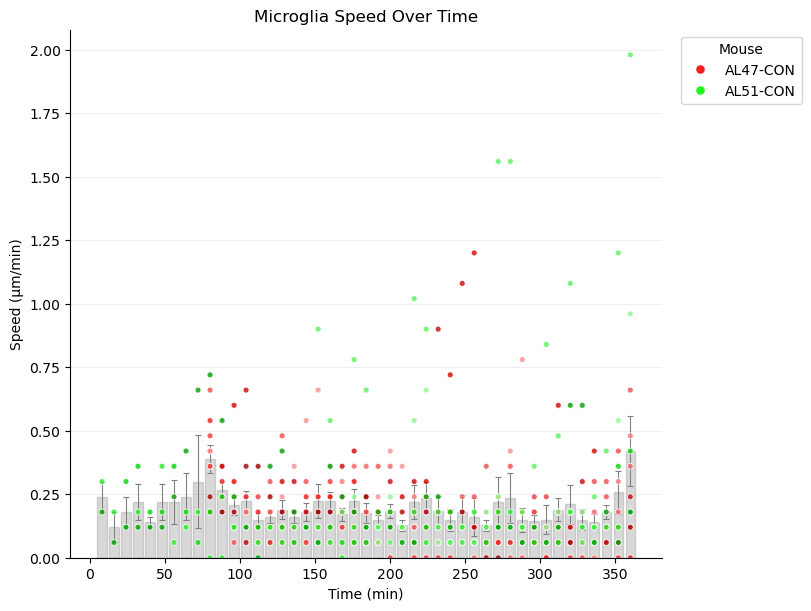

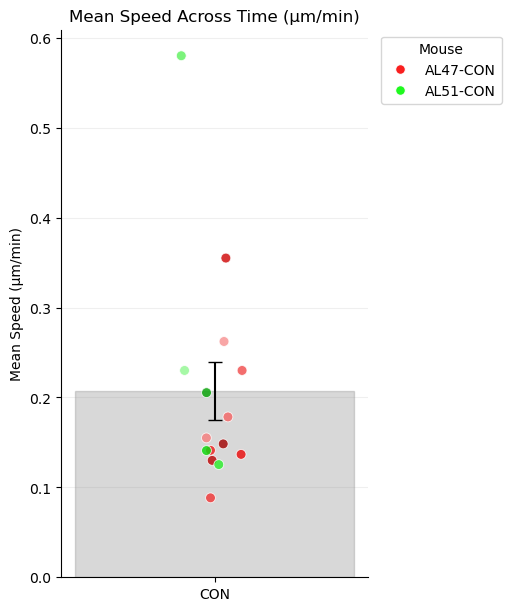

In [48]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorsys

# ---------------- User input ----------------
mouse_files = {
    'AL47-CON': '/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/Statistics/Combined Stats/CON/Unknown/AL47/Speed.csv',
    'AL51-CON': '/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/Statistics/Combined Stats/CON/Unknown/AL51/Speed.csv'
}
TIME_COL   = 'Time'
SPEED_COL  = 'Speed'
ID_COL     = 'MicrogliaID'   # used for per-cell shades
X_LABEL    = 'Time (min)'
Y_LABEL    = 'Speed (µm/min)'
TITLE_1    = 'Microglia Speed Over Time'
XTICK_2    = 'CON'
Y_LABEL_2  = 'Mean Speed (µm/min)'
TITLE_2    = 'Mean Speed Across Time (µm/min)'

np.random.seed(42)  # reproducible jitter

# ---------------- Color helpers ----------------
def _very_distinct_mouse_colors(mice, light=0.55, sat=0.95):
    """Fixed, human-friendly hue order; then evenly spaced if >10 mice."""
    H_BASE = [0.00, 1/3, 2/3, 5/6, 1/6, 0.50, 0.75, 1/12, 7/12, 11/12]
    if len(mice) <= len(H_BASE):
        hues = H_BASE[:len(mice)]
    else:
        hues = H_BASE + list(np.linspace(0, 1, len(mice) - len(H_BASE), endpoint=False))
    out = {}
    for m, h in zip(mice, hues):
        r, g, b = colorsys.hls_to_rgb(h, light, sat)  # HLS -> RGB
        out[m] = (r, g, b, 1.0)
    return out

def _rgb_to_hls(rgb):
    r, g, b = rgb[:3]
    return colorsys.rgb_to_hls(r, g, b)

def _hls_to_rgb(h, l, s):
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b, 1.0)

def _microglia_shades_by_mouse(df_all, mouse_colors, id_col,
                               light_min=0.35, light_max=0.78, sat=0.85):
    """
    For each mouse, assign each microglia ID a unique shade by varying lightness along that mouse's hue.
    Returns dict keyed by (mouse, str(ID)) -> RGBA.
    """
    shades = {}
    for mouse, base_rgb in mouse_colors.items():
        h_base, _, _ = _rgb_to_hls(base_rgb)
        if id_col in df_all.columns:
            gids = sorted(df_all.loc[df_all['Mouse'] == mouse, id_col].astype(str).unique())
        else:
            gids = []
        k = len(gids)
        if k <= 1:
            Ls = [0.55] if k == 1 else []
        else:
            Ls = np.linspace(light_min, light_max, k)
        for L, gid in zip(Ls, gids):
            shades[(mouse, gid)] = _hls_to_rgb(h_base, float(L), float(sat))
    return shades

def _legend_outside(ax, mouse_colors, include_mean=True, title="Mouse"):
    handles = []
    if include_mean:
        handles.append(
            plt.Line2D([0],[0], marker='s', linestyle='None',
                       markerfacecolor=(0.5,0.5,0.5,0.30),
                       markeredgecolor='grey', markeredgewidth=1.0,
                       label='Mean ± SEM', markersize=10)
        )
    for m in sorted(mouse_colors.keys()):
        handles.append(
            plt.Line2D([0],[0], marker='o', linestyle='None',
                       markerfacecolor=mouse_colors[m],
                       markeredgecolor='white', markeredgewidth=0.8,
                       label=str(m), markersize=7)
        )
    ax.legend(handles=handles, title=title,
              bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)

# ---------------- Load & prepare data ----------------
dfs = []
for mouse, path in mouse_files.items():
    df = pd.read_csv(path)
    df['Mouse'] = mouse
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all.columns = [c.strip() for c in df_all.columns]

# ID synonyms
if ID_COL not in df_all.columns:
    for cand in ['Microglia Id', 'Microglia_ID', 'CellID', 'TrackID']:
        if cand in df_all.columns:
            df_all = df_all.rename(columns={cand: ID_COL})
            break

# Coerce numeric and clean
df_all[TIME_COL]  = pd.to_numeric(df_all[TIME_COL], errors='coerce')
df_all[SPEED_COL] = pd.to_numeric(df_all[SPEED_COL], errors='coerce')
df_all = df_all.dropna(subset=['Mouse', TIME_COL, SPEED_COL])
if ID_COL in df_all.columns:
    df_all[ID_COL] = df_all[ID_COL].astype(str)

# Colors: base per mouse + per-microglia shades
mice = list(pd.unique(df_all['Mouse']))  # preserve first-seen order
mouse_colors = _very_distinct_mouse_colors(mice)
microglia_shades = _microglia_shades_by_mouse(df_all, mouse_colors, ID_COL)

# ==================== Plot 1: Speed over time (mean bar per timepoint) ====================
summary = (df_all
           .groupby(TIME_COL, as_index=False)[SPEED_COL]
           .agg(mean='mean', sem='sem'))

time_sorted = np.sort(summary[TIME_COL].to_numpy())
step = np.median(np.diff(time_sorted)) if len(time_sorted) > 1 else 1.0
bar_width = 0.8 * step if np.isfinite(step) and step > 0 else 0.5

fig1, ax1 = plt.subplots(figsize=(8, 6), layout="constrained")

ERROR_KW = dict(
    ecolor='grey',     # match your bar outline
    elinewidth=0.8,    # thinner vertical line
    capsize=2.0,       # shorter caps (in points)
    capthick=0.8       # thinner cap lines
)

ax1.bar(
    summary[TIME_COL], summary['mean'],
    width=bar_width,
    yerr=summary['sem'],
    error_kw=ERROR_KW,     # <— add this
    color='grey',
    alpha=0.30,
    edgecolor='grey',
    linewidth=1.0,
    zorder=1
)

# Scatter: per-point colored by (mouse, ID) shade; fallback to base mouse color
for m in mice:
    grp = df_all[df_all['Mouse'] == m]
    if ID_COL in grp.columns:
        colors = [microglia_shades.get((m, str(gid)), mouse_colors[m]) for gid in grp[ID_COL]]
    else:
        colors = [mouse_colors[m]] * len(grp)
    ax1.scatter(
        grp[TIME_COL], grp[SPEED_COL],
        s=18, alpha=0.85,
        color=colors,               # <-- use 'color', not 'c'
        edgecolors='white', linewidths=0.6,
        zorder=2
    )

# Labels & styling
ax1.set_xlabel(X_LABEL)
ax1.set_ylabel(Y_LABEL)
ax1.set_title(TITLE_1)
for side in ('top','right'):
    ax1.spines[side].set_visible(False)
ax1.yaxis.grid(True, linestyle='-', alpha=0.2)
ax1.set_axisbelow(True)

# Legend outside
_legend_outside(ax1, mouse_colors, include_mean=False, title="Mouse")

plt.show()

# ==================== Plot 2: Overall mean ± SEM + per-mouse microglia means ==============
if ID_COL in df_all.columns:
    per_cell = (df_all
                .dropna(subset=[ID_COL])
                .groupby(['Mouse', ID_COL], as_index=False)[SPEED_COL]
                .mean())
else:
    per_cell = df_all[['Mouse', SPEED_COL]].copy()
    per_cell[ID_COL] = np.arange(len(per_cell)).astype(str)

overall_mean = per_cell[SPEED_COL].mean()
overall_sem  = per_cell[SPEED_COL].sem()

fig2, ax2 = plt.subplots(figsize=(5, 6), layout="constrained")

# Mean bar (outlined)
x0 = 1.0
ax2.bar(
    x0, overall_mean, width=0.32,
    yerr=overall_sem, capsize=5,
    color='grey', alpha=0.30, edgecolor='grey', linewidth=1.0, zorder=1
)

# Scatter per-cell means with jitter; shade by (mouse, ID)
jitter_strength = 0.02
for m in mice:
    sub = per_cell[per_cell['Mouse'] == m]
    x = x0 + np.random.normal(0, jitter_strength, size=len(sub))
    colors = [microglia_shades.get((m, str(gid)), mouse_colors[m]) for gid in sub[ID_COL]]
    ax2.scatter(
        x, sub[SPEED_COL],
        s=50, alpha=0.85,
        color=colors,              # <-- use 'color'
        edgecolors='white', linewidths=0.6,
        zorder=2
    )

# Labels & styling
ax2.set_xticks([x0]); ax2.set_xticklabels([XTICK_2])
ax2.set_ylabel(Y_LABEL_2)
ax2.set_title(TITLE_2)
for side in ('top','right'):
    ax2.spines[side].set_visible(False)
ax2.yaxis.grid(True, linestyle='-', alpha=0.2)
ax2.set_axisbelow(True)

# Legend outside
_legend_outside(ax2, mouse_colors, include_mean=False, title="Mouse")

plt.show()
